In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import joblib
import seaborn as sns
import string
import warnings
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams
from collections import Counter
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

st = StandardScaler()
cnt=Counter()
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

In [2]:
log=pd.read_csv("D:\Codes\Python programming\Internship\log.csv")

In [3]:
consumerKey=log['key'][0]
consumerKeySecret=log['key'][1]
AccessToken=log['key'][2]
AccessTokenSecret=log['key'][3]

In [4]:
authenticate=tweepy.OAuthHandler(consumerKey,consumerKeySecret)
authenticate.set_access_token(AccessToken,AccessTokenSecret)
api = tweepy.API(authenticate, wait_on_rate_limit= True)

In [5]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
stopword = nltk.corpus.stopwords.words('english')

# Bitcoin

Collecting data and creating dataframe

In [7]:
keywords = '#Bitcoin'
limit=10000
tweets = tweepy.Cursor(api.search_tweets, q=keywords, count=10000,lang="en",tweet_mode='extended').items(limit)
columns = ['User', 'Tweet']
data = []
for tweet in tweets:
    data.append([tweet.user.screen_name, tweet.full_text])
bit1 = pd.DataFrame(data, columns=columns)
print(bit1)

Rate limit reached. Sleeping for: 239


                 User                                              Tweet
0           FaceOSApp  FaceOs has three main modes: VR, Metawold and ...
1          po93770377  RT @cryptoamazo: 🚨 $1,000 #GIVEAWAY 🚨\n\nTO EN...
2     Michell96311442          RT @TheMoonCarl: #Bitcoin breaking out!!!
3        CountBitcoin  Saylor:  Thinking of his next Bullish #Bitcoin...
4       CedYoungelman  RT @CedYoungelman: #99: Blue Collar #Bitcoin \...
...               ...                                                ...
9995         JiggzNsg  RT @AurelienOhayon: #BITCOIN BULLISH ROUNDING ...
9996    cryptoalerted  https://t.co/Fz8LuNGGiW (ZONE) went up 10.9 pe...
9997        wealth2me  "El Salvador to Buy Back Bonds After Bukele’s ...
9998      Shibainupay  @WallStreetSilv That reserve of value currency...
9999         DeFiGOD_  Is this currently a scam pump? 📉\nLet’s see wh...

[10000 rows x 2 columns]


Basic Cleaning removing emojis

In [8]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"# flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"                        
                           "]+", flags=re.UNICODE)
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#cryptocurrency', 'cryptocurrency', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text=emoji_pattern.sub(r'', text)
    return text
bit1['Tweet']= bit1['Tweet'].apply(cleanTxt)
bit1

,User,Tweet
0,FaceOSApp,"FaceOs has three main modes: VR, Metawold and ..."
1,po93770377,": $1,000 GIVEAWAY \n\nTO ENTER:\n\n FOLLOW Me..."
2,Michell96311442,: Bitcoin breaking out!!!
3,CountBitcoin,Saylor: Thinking of his next Bullish Bitcoin ...
4,CedYoungelman,: 99: Blue Collar Bitcoin \n\nIn this fun but ...
...,...,...
9995,JiggzNsg,: BITCOIN BULLISH ROUNDING BOTTOM PATTERN.\n\n...
9996,cryptoalerted,(ZONE) went up 10.9 percent in the last 1 min...
9997,wealth2me,"""El Salvador to Buy Back Bonds After Bukele’s ..."
9998,Shibainupay,That reserve of value currency already exists...


Preprocessing

In [9]:
#Creating new dataframe only for tweets
df_text=bit1[['Tweet']].astype(str)

#Coverting to lower Case
df_text['Lower_Tweet']=df_text['Tweet'].str.lower()

#Removing Punctions
punc_to_remove=string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punc_to_remove))

df_text["Tweet_Punc"]=df_text['Lower_Tweet'].apply(lambda text: remove_punctuation(text))

#Stopwords
",".join(stopwords.words("english"))
STOPWORDS=set(stopwords.words("english"))

def remove_stopword(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
df_text["Tweet_Stop"]=df_text['Tweet_Punc'].apply(lambda text: remove_stopword(text))

#Removal of frequently appeared word
for text in df_text['Tweet_Stop'].values:
    for word in text.split():
        cnt[word]+=1
        
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df_text["Tweet_Freq"] = df_text["Tweet_Stop"].apply(lambda text: remove_freqwords(text))
n_rare_word=10
RAREWORDS=set([w for (w ,wc) in cnt.most_common()[:-n_rare_word-1:-1]])

def remove_rareword(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df_text['Rare_text']=df_text['Tweet_Freq'].apply(lambda text: remove_rareword(text))

#Steamming data

stemmer=PorterStemmer()

def stem_porter(text):
        return " ".join([stemmer.stem(word) for word in text.split()])
    
df_text["Tweet_Stemmed"]=df_text['Tweet_Stop'].apply(lambda text : stem_porter(text))

#Lemmatization
lematizer=WordNetLemmatizer()
lemmmatizer=WordNetLemmatizer()

wordnet_map={"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatized_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lematizer.lemmatize(word , wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df_text["Tweet_Lemma"] = df_text["Tweet_Stop"].apply(lambda text: lemmatized_words(text))
#Dataframe
df_text

,Tweet,Lower_Tweet,Tweet_Punc,Tweet_Stop,Tweet_Freq,Rare_text,Tweet_Stemmed,Tweet_Lemma
0,"FaceOs has three main modes: VR, Metawold and ...","faceos has three main modes: vr, metawold and ...",faceos has three main modes vr metawold and li...,faceos three main modes vr metawold live mode ...,faceos three main modes vr metawold mode go si...,faceos three main modes vr metawold mode go si...,faceo three main mode vr metawold live mode go...,faceos three main mode vr metawold live mode g...
1,": $1,000 GIVEAWAY \n\nTO ENTER:\n\n FOLLOW Me...",": $1,000 giveaway \n\nto enter:\n\n follow me...",1000 giveaway \n\nto enter\n\n follow me \n...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...
2,: Bitcoin breaking out!!!,: bitcoin breaking out!!!,bitcoin breaking out,bitcoin breaking,breaking,breaking,bitcoin break,bitcoin breaking
3,Saylor: Thinking of his next Bullish Bitcoin ...,saylor: thinking of his next bullish bitcoin ...,saylor thinking of his next bullish bitcoin t...,saylor thinking next bullish bitcoin tweet 🤔,saylor thinking next bullish tweet 🤔,saylor thinking next bullish tweet 🤔,saylor think next bullish bitcoin tweet 🤔,saylor think next bullish bitcoin tweet 🤔
4,: 99: Blue Collar Bitcoin \n\nIn this fun but ...,: 99: blue collar bitcoin \n\nin this fun but ...,99 blue collar bitcoin \n\nin this fun but po...,99 blue collar bitcoin fun poignant episode si...,99 blue collar fun poignant episode sit w dan ...,99 blue collar fun poignant episode sit w dan ...,99 blue collar bitcoin fun poignant episod sit...,99 blue collar bitcoin fun poignant episode si...
...,...,...,...,...,...,...,...,...
9995,: BITCOIN BULLISH ROUNDING BOTTOM PATTERN.\n\n...,: bitcoin bullish rounding bottom pattern.\n\n...,bitcoin bullish rounding bottom pattern\n\nth...,bitcoin bullish rounding bottom pattern bear flag,bullish rounding bottom pattern bear flag,bullish rounding bottom pattern bear flag,bitcoin bullish round bottom pattern bear flag,bitcoin bullish round bottom pattern bear flag
9996,(ZONE) went up 10.9 percent in the last 1 min...,(zone) went up 10.9 percent in the last 1 min...,zone went up 109 percent in the last 1 minute...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minut zone crypto...,zone go 109 percent last 1 minute zone crypto ...
9997,"""El Salvador to Buy Back Bonds After Bukele’s ...","""el salvador to buy back bonds after bukele’s ...",el salvador to buy back bonds after bukele’s b...,el salvador buy back bonds bukele’s bad bitcoi...,el salvador buy back bonds bukele’s bad bets d...,el salvador buy back bonds bukele’s bad bets d...,el salvador buy back bond bukele’ bad bitcoin ...,el salvador buy back bond bukele’s bad bitcoin...
9998,That reserve of value currency already exists...,that reserve of value currency already exists...,that reserve of value currency already exists...,reserve value currency already exists called b...,reserve value currency already exists called u...,reserve value currency already exists called u...,reserv valu currenc alreadi exist call bitcoin...,reserve value currency already exist call bitc...


Frequently appeared words

In [10]:
for text in df_text['Tweet_Stop'].values:
    for word in text.split():
        cnt[word]+=1
        
cnt.most_common(10)

[('bitcoin', 12492),
 ('btc', 3828),
 ('using', 3458),
 ('world', 3438),
 ('metaverse', 3396),
 ('live', 3334),
 ('crypto', 3326),
 ('space', 3302),
 ('play', 3282),
 ('anyone', 3254)]

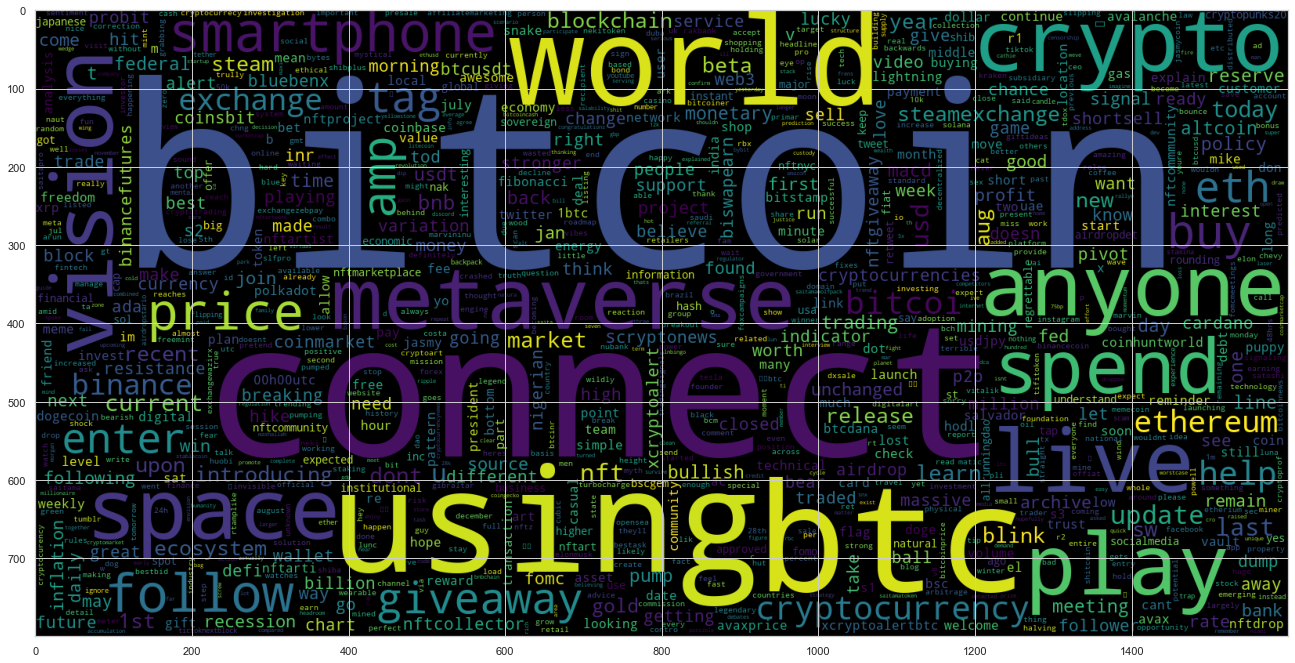

In [11]:
data_neg = df_text['Tweet_Stop'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Finding polarity and subjectivty

In [12]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df_text['Subjectivity'] = df_text['Tweet_Stop'].apply(getSubjectivity)
df_text['Polarity'] = df_text['Tweet_Stop'].apply(getPolarity)

df_text

,Tweet,Lower_Tweet,Tweet_Punc,Tweet_Stop,Tweet_Freq,Rare_text,Tweet_Stemmed,Tweet_Lemma,Subjectivity,Polarity
0,"FaceOs has three main modes: VR, Metawold and ...","faceos has three main modes: vr, metawold and ...",faceos has three main modes vr metawold and li...,faceos three main modes vr metawold live mode ...,faceos three main modes vr metawold mode go si...,faceos three main modes vr metawold mode go si...,faceo three main mode vr metawold live mode go...,faceos three main mode vr metawold live mode g...,0.416667,0.151515
1,": $1,000 GIVEAWAY \n\nTO ENTER:\n\n FOLLOW Me...",": $1,000 giveaway \n\nto enter:\n\n follow me...",1000 giveaway \n\nto enter\n\n follow me \n...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,0.000000,0.000000
2,: Bitcoin breaking out!!!,: bitcoin breaking out!!!,bitcoin breaking out,bitcoin breaking,breaking,breaking,bitcoin break,bitcoin breaking,0.000000,0.000000
3,Saylor: Thinking of his next Bullish Bitcoin ...,saylor: thinking of his next bullish bitcoin ...,saylor thinking of his next bullish bitcoin t...,saylor thinking next bullish bitcoin tweet 🤔,saylor thinking next bullish tweet 🤔,saylor thinking next bullish tweet 🤔,saylor think next bullish bitcoin tweet 🤔,saylor think next bullish bitcoin tweet 🤔,0.000000,0.000000
4,: 99: Blue Collar Bitcoin \n\nIn this fun but ...,: 99: blue collar bitcoin \n\nin this fun but ...,99 blue collar bitcoin \n\nin this fun but po...,99 blue collar bitcoin fun poignant episode si...,99 blue collar fun poignant episode sit w dan ...,99 blue collar fun poignant episode sit w dan ...,99 blue collar bitcoin fun poignant episod sit...,99 blue collar bitcoin fun poignant episode si...,0.266667,0.100000
...,...,...,...,...,...,...,...,...,...,...
9995,: BITCOIN BULLISH ROUNDING BOTTOM PATTERN.\n\n...,: bitcoin bullish rounding bottom pattern.\n\n...,bitcoin bullish rounding bottom pattern\n\nth...,bitcoin bullish rounding bottom pattern bear flag,bullish rounding bottom pattern bear flag,bullish rounding bottom pattern bear flag,bitcoin bullish round bottom pattern bear flag,bitcoin bullish round bottom pattern bear flag,0.000000,0.000000
9996,(ZONE) went up 10.9 percent in the last 1 min...,(zone) went up 10.9 percent in the last 1 min...,zone went up 109 percent in the last 1 minute...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minut zone crypto...,zone go 109 percent last 1 minute zone crypto ...,0.066667,0.000000
9997,"""El Salvador to Buy Back Bonds After Bukele’s ...","""el salvador to buy back bonds after bukele’s ...",el salvador to buy back bonds after bukele’s b...,el salvador buy back bonds bukele’s bad bitcoi...,el salvador buy back bonds bukele’s bad bets d...,el salvador buy back bonds bukele’s bad bets d...,el salvador buy back bond bukele’ bad bitcoin ...,el salvador buy back bond bukele’s bad bitcoin...,0.305556,-0.016667
9998,That reserve of value currency already exists...,that reserve of value currency already exists...,that reserve of value currency already exists...,reserve value currency already exists called b...,reserve value currency already exists called u...,reserve value currency already exists called u...,reserv valu currenc alreadi exist call bitcoin...,reserve value currency already exist call bitc...,0.000000,0.000000


Sentiment

In [13]:
def analysis(score):
    if score<0:
        return 'negative'
    elif score==0:
        return 'neutral'
    else:
        return 'positive'
df_text['Sentiment']=df_text['Polarity'].apply(analysis)
df_text

,Tweet,Lower_Tweet,Tweet_Punc,Tweet_Stop,Tweet_Freq,Rare_text,Tweet_Stemmed,Tweet_Lemma,Subjectivity,Polarity,Sentiment
0,"FaceOs has three main modes: VR, Metawold and ...","faceos has three main modes: vr, metawold and ...",faceos has three main modes vr metawold and li...,faceos three main modes vr metawold live mode ...,faceos three main modes vr metawold mode go si...,faceos three main modes vr metawold mode go si...,faceo three main mode vr metawold live mode go...,faceos three main mode vr metawold live mode g...,0.416667,0.151515,positive
1,": $1,000 GIVEAWAY \n\nTO ENTER:\n\n FOLLOW Me...",": $1,000 giveaway \n\nto enter:\n\n follow me...",1000 giveaway \n\nto enter\n\n follow me \n...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,0.000000,0.000000,neutral
2,: Bitcoin breaking out!!!,: bitcoin breaking out!!!,bitcoin breaking out,bitcoin breaking,breaking,breaking,bitcoin break,bitcoin breaking,0.000000,0.000000,neutral
3,Saylor: Thinking of his next Bullish Bitcoin ...,saylor: thinking of his next bullish bitcoin ...,saylor thinking of his next bullish bitcoin t...,saylor thinking next bullish bitcoin tweet 🤔,saylor thinking next bullish tweet 🤔,saylor thinking next bullish tweet 🤔,saylor think next bullish bitcoin tweet 🤔,saylor think next bullish bitcoin tweet 🤔,0.000000,0.000000,neutral
4,: 99: Blue Collar Bitcoin \n\nIn this fun but ...,: 99: blue collar bitcoin \n\nin this fun but ...,99 blue collar bitcoin \n\nin this fun but po...,99 blue collar bitcoin fun poignant episode si...,99 blue collar fun poignant episode sit w dan ...,99 blue collar fun poignant episode sit w dan ...,99 blue collar bitcoin fun poignant episod sit...,99 blue collar bitcoin fun poignant episode si...,0.266667,0.100000,positive
...,...,...,...,...,...,...,...,...,...,...,...
9995,: BITCOIN BULLISH ROUNDING BOTTOM PATTERN.\n\n...,: bitcoin bullish rounding bottom pattern.\n\n...,bitcoin bullish rounding bottom pattern\n\nth...,bitcoin bullish rounding bottom pattern bear flag,bullish rounding bottom pattern bear flag,bullish rounding bottom pattern bear flag,bitcoin bullish round bottom pattern bear flag,bitcoin bullish round bottom pattern bear flag,0.000000,0.000000,neutral
9996,(ZONE) went up 10.9 percent in the last 1 min...,(zone) went up 10.9 percent in the last 1 min...,zone went up 109 percent in the last 1 minute...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minut zone crypto...,zone go 109 percent last 1 minute zone crypto ...,0.066667,0.000000,neutral
9997,"""El Salvador to Buy Back Bonds After Bukele’s ...","""el salvador to buy back bonds after bukele’s ...",el salvador to buy back bonds after bukele’s b...,el salvador buy back bonds bukele’s bad bitcoi...,el salvador buy back bonds bukele’s bad bets d...,el salvador buy back bonds bukele’s bad bets d...,el salvador buy back bond bukele’ bad bitcoin ...,el salvador buy back bond bukele’s bad bitcoin...,0.305556,-0.016667,negative
9998,That reserve of value currency already exists...,that reserve of value currency already exists...,that reserve of value currency already exists...,reserve value currency already exists called b...,reserve value currency already exists called u...,reserve value currency already exists called u...,reserv valu currenc alreadi exist call bitcoin...,reserve value currency already exist call bitc...,0.000000,0.000000,neutral


Vizualization for sentiment in bitcoin tweets

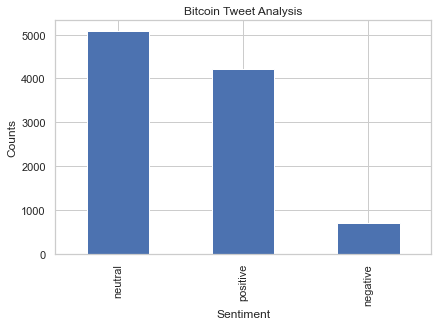

In [14]:
df_text['Sentiment'].value_counts()
plt.title('Bitcoin Tweet Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_text['Sentiment'].value_counts().plot(kind='bar')
plt.show()

Creating CSV file

In [15]:
df_text.to_csv(r'D:\Codes\Python programming\Internship\Bit1.csv', index=False)

Unigram

In [16]:
c_vec = CountVectorizer(stop_words=stopword, ngram_range=(0,1))

# matrix of ngrams
ngrams = c_vec.fit_transform(df_text['Tweet_Stop'])

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'Frequency', 1:'Unigram'})
df_ngram['Polarity'] = df_ngram['Unigram'].apply(lambda x: TextBlob(x).polarity)
df_ngram['Subjective'] = df_ngram['Unigram'].apply(lambda x: TextBlob(x).subjectivity)

#Sentiment
def analysis(score):
    if score<=-0.6:
        return 'negative'
    elif score==0.4:
        return 'neutral'
    elif score>=0.5:
        return 'positive'
df_ngram['Sentiment']=df_ngram['Polarity'].apply(analysis)


df_ngram = df_ngram[df_ngram["Sentiment"].str.contains("None") == False]

df_ngram

,Frequency,Unigram,Polarity,Subjective,Sentiment
76,197,win,0.80,0.4,positive
97,164,good,0.70,0.6,positive
106,139,top,0.50,0.5,positive
140,112,love,0.50,0.6,positive
176,92,best,1.00,0.3,positive
...,...,...,...,...,...
7731,1,beautifully,0.85,1.0,positive
7752,1,base,-0.80,1.0,negative
7788,1,attractive,0.80,1.0,positive
7800,1,atrocious,-0.70,1.0,negative


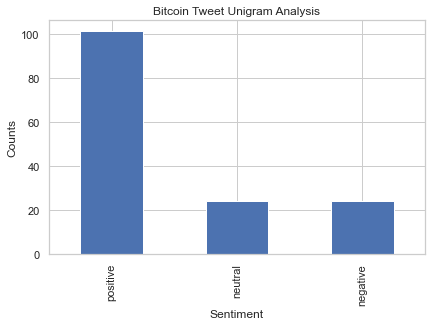

In [17]:
#Unigram Vizualization
df_ngram['Sentiment'].value_counts()
plt.title('Bitcoin Tweet Unigram Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_ngram['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [18]:
ptweet=df_ngram[df_ngram.Sentiment=='positive']
ptweet

,Frequency,Unigram,Polarity,Subjective,Sentiment
76,197,win,0.80,0.4,positive
97,164,good,0.70,0.6,positive
106,139,top,0.50,0.5,positive
140,112,love,0.50,0.6,positive
176,92,best,1.00,0.3,positive
...,...,...,...,...,...
7175,1,delicious,1.00,1.0,positive
7514,1,catching,0.60,0.9,positive
7607,1,brilliantly,0.90,1.0,positive
7731,1,beautifully,0.85,1.0,positive


In [19]:
ntweet=df_ngram[df_ngram.Sentiment=='negative']
ntweet

,Frequency,Unigram,Polarity,Subjective,Sentiment
715,22,bad,-0.70,0.666667,negative
814,18,terrible,-1.00,1.000000,negative
1000,14,cold,-0.60,1.000000,negative
1367,9,stupid,-0.80,1.000000,negative
1552,8,desperate,-0.60,1.000000,negative
1594,7,worst,-1.00,1.000000,negative
1884,6,crazy,-0.60,0.900000,negative
2106,5,hate,-0.80,0.900000,negative
2116,5,fucking,-0.60,0.800000,negative
2990,3,grim,-1.00,1.000000,negative


In [20]:
nutweet=df_ngram[df_ngram.Sentiment=='neutral']
nutweet

,Frequency,Unigram,Polarity,Subjective,Sentiment
218,78,free,0.4,0.80,neutral
419,39,available,0.4,0.40,neutral
458,35,sound,0.4,0.40,neutral
661,24,important,0.4,1.00,neutral
950,15,enjoy,0.4,0.50,neutral
1084,12,secure,0.4,0.60,neutral
1499,8,primary,0.4,0.50,neutral
1578,8,advanced,0.4,0.60,neutral
1860,6,fantastic,0.4,0.90,neutral
1887,6,confirmed,0.4,1.00,neutral


Bigram

In [21]:
c_vec = CountVectorizer(stop_words=stopword, ngram_range=(2,2))

# matrix of ngrams
ngrams = c_vec.fit_transform(df_text['Tweet_Stop'])

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df_ngram1 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'Frequency', 1:'Bigram'})
df_ngram1['Polarity'] = df_ngram1['Bigram'].apply(lambda x: TextBlob(x).polarity)
df_ngram1['Subjective'] = df_ngram1['Bigram'].apply(lambda x: TextBlob(x).subjectivity)

#Sentiment
def analysis(score):
    if score<=-0.6:
        return 'negative'
    elif score==0.4:
        return 'neutral'
    elif score>=0.6:
        return 'positive'
df_ngram1['Sentiment']=df_ngram1['Polarity'].apply(analysis)


df_ngram1 = df_ngram1[df_ngram1["Sentiment"].str.contains("None") == False]

df_ngram1

,Frequency,Bigram,Polarity,Subjective,Sentiment
79,122,chance win,0.8,0.4,positive
91,104,win 100,0.8,0.4,positive
125,82,win year,0.8,0.4,positive
144,76,coinhuntworld awesome,1.0,1.0,positive
147,74,awesome cryptocurrency,1.0,1.0,positive
...,...,...,...,...,...
26455,1,2400 happy,0.8,1.0,positive
27290,1,2022 best,1.0,0.3,positive
27324,1,2021 best,1.0,0.3,positive
27351,1,200wma fair,0.7,0.9,positive


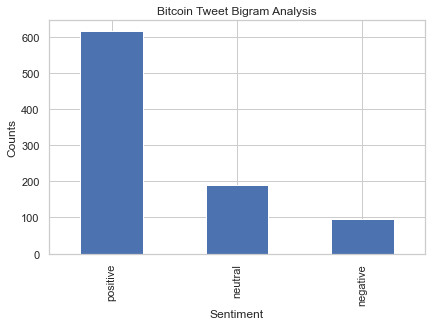

In [22]:
#Bigram Vizualization
df_ngram1['Sentiment'].value_counts()
plt.title('Bitcoin Tweet Bigram Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_ngram1['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [23]:
ptweet1=df_ngram1[df_ngram1.Sentiment=='positive']
ptweet1

,Frequency,Bigram,Polarity,Subjective,Sentiment
79,122,chance win,0.8,0.4,positive
91,104,win 100,0.8,0.4,positive
125,82,win year,0.8,0.4,positive
144,76,coinhuntworld awesome,1.0,1.0,positive
147,74,awesome cryptocurrency,1.0,1.0,positive
...,...,...,...,...,...
25877,1,51 best,1.0,0.3,positive
26455,1,2400 happy,0.8,1.0,positive
27290,1,2022 best,1.0,0.3,positive
27324,1,2021 best,1.0,0.3,positive


In [24]:
ntweet1=df_ngram1[df_ngram1.Sentiment=='negative']
ntweet1

,Frequency,Bigram,Polarity,Subjective,Sentiment
675,18,terrible market,-1.0,1.000000,negative
690,18,fomcmeetings terrible,-1.0,1.000000,negative
907,12,usa cold,-0.6,1.000000,negative
960,12,cold bitcoin,-0.6,1.000000,negative
1890,6,durbin bad,-0.7,0.666667,negative
...,...,...,...,...,...
24453,1,bad day,-0.7,0.666667,negative
24454,1,bad correlated,-0.7,0.666667,negative
24680,1,artificially propped,-0.6,1.000000,negative
25173,1,ah crap,-0.8,0.800000,negative


In [25]:
nutweet1=df_ngram1[df_ngram1.Sentiment=='neutral']
nutweet1

,Frequency,Bigram,Polarity,Subjective,Sentiment
388,30,parts available,0.4,0.4,neutral
593,22,free mint,0.4,0.8,neutral
751,16,snakes free,0.4,0.8,neutral
883,13,important take,0.4,1.0,neutral
1453,8,free bitcoin,0.4,0.8,neutral
...,...,...,...,...,...
25397,1,absolutely free,0.4,0.8,neutral
25888,1,5000 free,0.4,0.8,neutral
25893,1,500 free,0.4,0.8,neutral
26140,1,31st available,0.4,0.4,neutral


Trigram

In [26]:
c_vec = CountVectorizer(stop_words=stopword, ngram_range=(3,3))

# matrix of ngrams
ngrams = c_vec.fit_transform(df_text['Tweet_Stop'])

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df_ngram2 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'Frequency', 1:'Trigram'})
df_ngram2['Polarity'] = df_ngram2['Trigram'].apply(lambda x: TextBlob(x).polarity)
df_ngram2['Subjective'] = df_ngram2['Trigram'].apply(lambda x: TextBlob(x).subjectivity)

#Sentiment
def analysis(score):
    if score<=-0.6:
        return 'negative'
    elif score==0.4:
        return 'neutral'
    elif score>=0.7:
        return 'positive'
df_ngram2['Sentiment']=df_ngram2['Polarity'].apply(analysis)


df_ngram2 = df_ngram2[df_ngram2["Sentiment"].str.contains("None") == False]

df_ngram2

,Frequency,Trigram,Polarity,Subjective,Sentiment
100,82,video chance win,0.8,0.4,positive
107,82,chance win year,0.8,0.4,positive
110,81,win year ac,0.8,0.4,positive
112,76,playing coinhuntworld awesome,1.0,1.0,positive
116,74,coinhuntworld awesome cryptocurrency,1.0,1.0,positive
...,...,...,...,...,...
30798,1,15 minutes enjoy,0.4,0.5,neutral
30911,1,12 months good,0.7,0.6,positive
31115,1,100 risk free,0.4,0.8,neutral
31121,1,100 guarantee win,0.8,0.4,positive


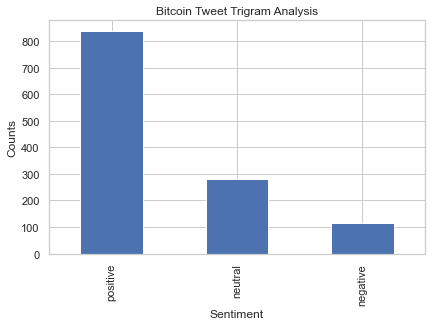

In [27]:
#Trigram Vizualization
df_ngram2['Sentiment'].value_counts()
plt.title('Bitcoin Tweet Trigram Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_ngram2['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [28]:
ptweet2=df_ngram2[df_ngram2.Sentiment=='positive']
ptweet2

,Frequency,Trigram,Polarity,Subjective,Sentiment
100,82,video chance win,0.8,0.4,positive
107,82,chance win year,0.8,0.4,positive
110,81,win year ac,0.8,0.4,positive
112,76,playing coinhuntworld awesome,1.0,1.0,positive
116,74,coinhuntworld awesome cryptocurrency,1.0,1.0,positive
...,...,...,...,...,...
30285,1,2022 best way,1.0,0.3,positive
30321,1,2021 best article,1.0,0.3,positive
30348,1,200wma fair market,0.7,0.9,positive
30911,1,12 months good,0.7,0.6,positive


In [29]:
ntweet2=df_ngram2[df_ngram2.Sentiment=='negative']
ntweet2

,Frequency,Trigram,Polarity,Subjective,Sentiment
573,18,terrible market think,-1.0,1.000000,negative
587,18,fomcmeetings terrible market,-1.0,1.000000,negative
787,12,usa cold bitcoin,-0.6,1.000000,negative
806,12,park usa cold,-0.6,1.000000,negative
835,12,cold bitcoin winter,-0.6,1.000000,negative
...,...,...,...,...,...
27283,1,bad bitcoin mcdonalds,-0.7,0.666667,negative
27284,1,bad bitcoin eth,-0.7,0.666667,negative
27588,1,artificially propped 401k,-0.6,1.000000,negative
28158,1,ah crap go,-0.8,0.800000,negative


In [30]:
nutweet2=df_ngram2[df_ngram2.Sentiment=='neutral']
nutweet2

,Frequency,Trigram,Polarity,Subjective,Sentiment
321,30,service parts available,0.4,0.4,neutral
653,16,snakes free mint,0.4,0.8,neutral
768,13,important take custody,0.4,1.0,neutral
825,12,free mint soon,0.4,0.8,neutral
1314,7,whalerider advanced trading,0.4,0.6,neutral
...,...,...,...,...,...
29314,1,251 yes sound,0.4,0.4,neutral
30369,1,200 ticket free,0.4,0.8,neutral
30798,1,15 minutes enjoy,0.4,0.5,neutral
31115,1,100 risk free,0.4,0.8,neutral


Load Dataset

In [31]:
data = pd.read_csv("D:\Codes\Python programming\Internship\Bit1.csv")
data

,Tweet,Lower_Tweet,Tweet_Punc,Tweet_Stop,Tweet_Freq,Rare_text,Tweet_Stemmed,Tweet_Lemma,Subjectivity,Polarity,Sentiment
0,"FaceOs has three main modes: VR, Metawold and ...","faceos has three main modes: vr, metawold and ...",faceos has three main modes vr metawold and li...,faceos three main modes vr metawold live mode ...,faceos three main modes vr metawold mode go si...,faceos three main modes vr metawold mode go si...,faceo three main mode vr metawold live mode go...,faceos three main mode vr metawold live mode g...,0.416667,0.151515,positive
1,": $1,000 GIVEAWAY \n\nTO ENTER:\n\n FOLLOW Me...",": $1,000 giveaway \n\nto enter:\n\n follow me...",1000 giveaway \n\nto enter\n\n follow me \n...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,1000 giveaway enter follow like amp tag 3 help...,0.000000,0.000000,neutral
2,: Bitcoin breaking out!!!,: bitcoin breaking out!!!,bitcoin breaking out,bitcoin breaking,breaking,breaking,bitcoin break,bitcoin breaking,0.000000,0.000000,neutral
3,Saylor: Thinking of his next Bullish Bitcoin ...,saylor: thinking of his next bullish bitcoin ...,saylor thinking of his next bullish bitcoin t...,saylor thinking next bullish bitcoin tweet 🤔,saylor thinking next bullish tweet 🤔,saylor thinking next bullish tweet 🤔,saylor think next bullish bitcoin tweet 🤔,saylor think next bullish bitcoin tweet 🤔,0.000000,0.000000,neutral
4,: 99: Blue Collar Bitcoin \n\nIn this fun but ...,: 99: blue collar bitcoin \n\nin this fun but ...,99 blue collar bitcoin \n\nin this fun but po...,99 blue collar bitcoin fun poignant episode si...,99 blue collar fun poignant episode sit w dan ...,99 blue collar fun poignant episode sit w dan ...,99 blue collar bitcoin fun poignant episod sit...,99 blue collar bitcoin fun poignant episode si...,0.266667,0.100000,positive
...,...,...,...,...,...,...,...,...,...,...,...
9995,: BITCOIN BULLISH ROUNDING BOTTOM PATTERN.\n\n...,: bitcoin bullish rounding bottom pattern.\n\n...,bitcoin bullish rounding bottom pattern\n\nth...,bitcoin bullish rounding bottom pattern bear flag,bullish rounding bottom pattern bear flag,bullish rounding bottom pattern bear flag,bitcoin bullish round bottom pattern bear flag,bitcoin bullish round bottom pattern bear flag,0.000000,0.000000,neutral
9996,(ZONE) went up 10.9 percent in the last 1 min...,(zone) went up 10.9 percent in the last 1 min...,zone went up 109 percent in the last 1 minute...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minutes zone cryp...,zone went 109 percent last 1 minut zone crypto...,zone go 109 percent last 1 minute zone crypto ...,0.066667,0.000000,neutral
9997,"""El Salvador to Buy Back Bonds After Bukele’s ...","""el salvador to buy back bonds after bukele’s ...",el salvador to buy back bonds after bukele’s b...,el salvador buy back bonds bukele’s bad bitcoi...,el salvador buy back bonds bukele’s bad bets d...,el salvador buy back bonds bukele’s bad bets d...,el salvador buy back bond bukele’ bad bitcoin ...,el salvador buy back bond bukele’s bad bitcoin...,0.305556,-0.016667,negative
9998,That reserve of value currency already exists...,that reserve of value currency already exists...,that reserve of value currency already exists...,reserve value currency already exists called b...,reserve value currency already exists called u...,reserve value currency already exists called u...,reserv valu currenc alreadi exist call bitcoin...,reserve value currency already exist call bitc...,0.000000,0.000000,neutral


Naive Bayes

In [32]:
#Encoding Labels and Making Train-Test Splits
x= data['Tweet_Stop'].values
y = data['Sentiment'].values
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)

# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x).toarray()
x_test = vec.transform(x_test).toarray()

#Building the Naive Bayes Classifier
model = MultinomialNB()
model.fit(x, y)
a=model.score(x_test, y_test)
print("Naive Bayes Accuracy score for Bitcoin:",a)

Naive Bayes Accuracy score for Bitcoin: 0.9004


In [33]:
model.predict(vec.transform(["Bitcoin is worst"]))

array(['negative'], dtype='<U8')

Logistic Regression

In [34]:
data = pd.read_csv("D:\Codes\Python programming\Internship\Bit1.csv")
data
x= data['Tweet_Stop'].values
y = data['Sentiment'].values
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.4, random_state=101)

# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x).toarray()
x_test = vec.transform(x_test).toarray()
classifier= LogisticRegression(random_state=0)  
classifier.fit(x, y)  
b=classifier.score(x_test,y_test)
print("Logistic Regression Accuracy score for Bitcoin:",a)

Logistic Regression Accuracy score for Bitcoin: 0.9004


In [35]:
predictions=classifier.predict(x_test)

In [36]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    negative       0.96      0.70      0.81       283
     neutral       0.92      0.98      0.95      2030
    positive       0.96      0.93      0.95      1687

    accuracy                           0.94      4000
   macro avg       0.95      0.87      0.90      4000
weighted avg       0.94      0.94      0.94      4000



In [37]:
confusion_matrix(y_test,predictions)

array([[ 198,   58,   27],
       [   2, 1990,   38],
       [   7,  106, 1574]], dtype=int64)

KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
error_rates=[]
for k in range(1,40):
    knn=KNeighborsClassifier(n_neighbors=k)
x= data['Tweet_Stop'].values
y = data['Sentiment'].values
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)
# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x).toarray()
x_test = vec.transform(x_test).toarray()
knn.fit(x_test,y_test)
    #pred=knn.predict(x_test)
    #error_rates.append(np.sum(y_test != pred))
knn=KNeighborsClassifier(n_neighbors=10,p=1)
knn.fit(x_test,y_test)
knn_pred=knn.predict(x_test)
print(classification_report(knn_pred,y_test))
#plt.plot(list(range(1,40)),error_rates,marker='o',mfc='red',mec='red',ms=5,ls='--')
e=knn.score(x_test,y_test)
print("Accuracy score in KNN of bitcoin is ",e)

              precision    recall  f1-score   support

    negative       0.27      1.00      0.42        47
     neutral       1.00      0.70      0.82      1816
    positive       0.60      1.00      0.75       637

    accuracy                           0.78      2500
   macro avg       0.62      0.90      0.66      2500
weighted avg       0.88      0.78      0.80      2500

Accuracy score in KNN of bitcoin is  0.7796


SVM

In [39]:
svc=SVC(C=8,kernel='linear',degree=4)
svc.fit(x,y)
g=svc.score(x_test,y_test)
print("Accuracy score in SVM is ",g)

Accuracy score in SVM is  0.9492


In [40]:
pred=svc.predict(x_test)

In [41]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.86      0.82      0.84       177
     neutral       0.94      0.98      0.96      1269
    positive       0.97      0.94      0.95      1054

    accuracy                           0.95      2500
   macro avg       0.93      0.91      0.92      2500
weighted avg       0.95      0.95      0.95      2500



Random Forest Classifier

In [42]:
rf=RandomForestClassifier(n_estimators=20)
rf.fit(x,y)
h=rf.score(x_test,y_test)
print("Accuracy score in Random Forest Classifier is ",h)

Accuracy score in Random Forest Classifier is  0.9412


In [43]:
pred=rf.predict(x_test)

In [44]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.97      0.75      0.84       177
     neutral       0.92      0.98      0.95      1269
    positive       0.97      0.93      0.95      1054

    accuracy                           0.94      2500
   macro avg       0.95      0.88      0.91      2500
weighted avg       0.94      0.94      0.94      2500



# Ethereum

Collecting data and creating dataframe

In [46]:
keywords = '#ETH'
limit=10000
tweets = tweepy.Cursor(api.search_tweets, q=keywords, count=10000,lang="en",tweet_mode='extended').items(limit)
columns = ['User', 'Tweet']
data = []
for tweet in tweets:
    data.append([tweet.user.screen_name, tweet.full_text])
eth1 = pd.DataFrame(data, columns=columns)
print(eth1)

                User                                              Tweet
0         oxzyeleven  RT @Steam_Exchange: Don't blink! BETA Release ...
1          Njiforti3  RT @Soulmaster3000: @IvanMar77546602 @storm290...
2            0_Merab  RT @Steam_Exchange: Don't blink! BETA Release ...
3     Super_Bigwin77  RT @LeekyNFT: 🎁#GIVEAWAY!🎁 \n\nPrize:🏆 2X NFT\...
4        nanajeanava  RT @7777Humans: 🪐 WHITELIST GIVEAWAY! 🪐\n\nWe ...
...              ...                                                ...
9995     SawKyibel11  RT @ETHPNFTUNK: First 1500 People Retweet will...
9996  Friskilabigwin  RT @EduardRoss_: Hey guys, if I give you $1000...
9997    osyarifullah  RT @KonnedToken: 💸 5,000,000 Konned Token #Giv...
9998     AllowGod420  RT @Nftdabster: Shill me your unique #NFT unde...
9999  jaykays_taeger  RT @Steam_Exchange: Don't blink! BETA Release ...

[10000 rows x 2 columns]


Basic Cleaning removing emojis

In [47]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"# flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"                        
                           "]+", flags=re.UNICODE)
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text=emoji_pattern.sub(r'', text)
    return text
eth1['Tweet']= eth1['Tweet'].apply(cleanTxt)
eth1

,User,Tweet
0,oxzyeleven,_Exchange: Don't blink! BETA Release of the St...
1,Njiforti3,: _FTX …
2,0_Merab,_Exchange: Don't blink! BETA Release of the St...
3,Super_Bigwin77,: GIVEAWAY! \n\nPrize: 2X NFT\n\nMust:\n1⃣ Fol...
4,nanajeanava,: 🪐 WHITELIST GIVEAWAY! 🪐\n\nWe will be giving...
...,...,...
9995,SawKyibel11,: First 1500 People Retweet will receive $ETH...
9996,Friskilabigwin,"_: Hey guys, if I give you $1000, which crypto..."
9997,osyarifullah,": 5,000,000 Konned Token Giveaway Round 1\n\..."
9998,AllowGod420,: Shill me your unique NFT under 2 ETH 🦄🦄


Preprocessing

In [48]:
#Creating new dataframe only for tweets
df1_text=eth1[['Tweet']].astype(str)

#Coverting to lower Case
df1_text['Lower_Tweet']=df1_text['Tweet'].str.lower()

#Removing Punctions
punc_to_remove=string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punc_to_remove))

df1_text["Tweet_Punc"]=df1_text['Lower_Tweet'].apply(lambda text: remove_punctuation(text))

#Stopwords
",".join(stopwords.words("english"))
STOPWORDS=set(stopwords.words("english"))

def remove_stopword(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
df1_text["Tweet_Stop"]=df1_text['Tweet_Punc'].apply(lambda text: remove_stopword(text))

#Removal of frequently appeared word
for text in df_text['Tweet_Stop'].values:
    for word in text.split():
        cnt[word]+=1
        
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df1_text["Tweet_Freq"] = df1_text["Tweet_Stop"].apply(lambda text: remove_freqwords(text))
n_rare_word=10
RAREWORDS=set([w for (w ,wc) in cnt.most_common()[:-n_rare_word-1:-1]])

def remove_rareword(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df1_text['Rare_text']=df1_text['Tweet_Freq'].apply(lambda text: remove_rareword(text))

#Steamming data

stemmer=PorterStemmer()

def stem_porter(text):
        return " ".join([stemmer.stem(word) for word in text.split()])
    
df1_text["Tweet_Stemmed"]=df1_text['Tweet_Stop'].apply(lambda text : stem_porter(text))

#Lemmatization
lematizer=WordNetLemmatizer()
lemmmatizer=WordNetLemmatizer()

wordnet_map={"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatized_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lematizer.lemmatize(word , wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df1_text["Tweet_Lemma"] = df1_text["Tweet_Stop"].apply(lambda text: lemmatized_words(text))
#Dataframe
df1_text

,Tweet,Lower_Tweet,Tweet_Punc,Tweet_Stop,Tweet_Freq,Rare_text,Tweet_Stemmed,Tweet_Lemma
0,_Exchange: Don't blink! BETA Release of the St...,_exchange: don't blink! beta release of the st...,exchange dont blink beta release of the steame...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchang dont blink beta releas steamexchang ec...,exchange dont blink beta release steamexchange...
1,: _FTX …,: _ftx …,ftx …,ftx …,ftx …,ftx …,ftx …,ftx …
2,_Exchange: Don't blink! BETA Release of the St...,_exchange: don't blink! beta release of the st...,exchange dont blink beta release of the steame...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchang dont blink beta releas steamexchang ec...,exchange dont blink beta release steamexchange...
3,: GIVEAWAY! \n\nPrize: 2X NFT\n\nMust:\n1⃣ Fol...,: giveaway! \n\nprize: 2x nft\n\nmust:\n1⃣ fol...,giveaway \n\nprize 2x nft\n\nmust\n1⃣ follow ...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...
4,: 🪐 WHITELIST GIVEAWAY! 🪐\n\nWe will be giving...,: 🪐 whitelist giveaway! 🪐\n\nwe will be giving...,🪐 whitelist giveaway 🪐\n\nwe will be giving a...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 give away • 2x guarante...,🪐 whitelist giveaway 🪐 give away • 2x guarante...
...,...,...,...,...,...,...,...,...
9995,: First 1500 People Retweet will receive $ETH...,: first 1500 people retweet will receive $eth...,first 1500 people retweet will receive eth 1...,first 1500 people retweet receive eth 10000 fo...,first 1500 people retweet receive eth 10000 fo...,first 1500 people retweet receive eth 10000 fo...,first 1500 peopl retweet receiv eth 10000 foll...,first 1500 people retweet receive eth 10000 fo...
9996,"_: Hey guys, if I give you $1000, which crypto...","_: hey guys, if i give you $1000, which crypto...",hey guys if i give you 1000 which cryptocurre...,hey guys give 1000 cryptocurrency would invest...,hey guys give 1000 cryptocurrency would invest...,hey guys give 1000 cryptocurrency would invest...,hey guy give 1000 cryptocurr would invest 🤔 10...,hey guy give 1000 cryptocurrency would invest ...
9997,": 5,000,000 Konned Token Giveaway Round 1\n\...",": 5,000,000 konned token giveaway round 1\n\...",5000000 konned token giveaway round 1\n\nru...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 kon token giveaway round 1 rule 1⃣ sen...,5000000 konned token giveaway round 1 rule 1⃣ ...
9998,: Shill me your unique NFT under 2 ETH 🦄🦄,: shill me your unique nft under 2 eth 🦄🦄,shill me your unique nft under 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill uniqu nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄


Frequently appeared words

In [49]:
for text in df1_text['Tweet_Stop'].values:
    for word in text.split():
        cnt[word]+=1
        
cnt.most_common(10)

[('bitcoin', 19229),
 ('follow', 9200),
 ('eth', 8578),
 ('amp', 7390),
 ('btc', 7024),
 ('crypto', 5631),
 ('like', 5600),
 ('giveaway', 5363),
 ('metaverse', 5294),
 ('world', 5207)]

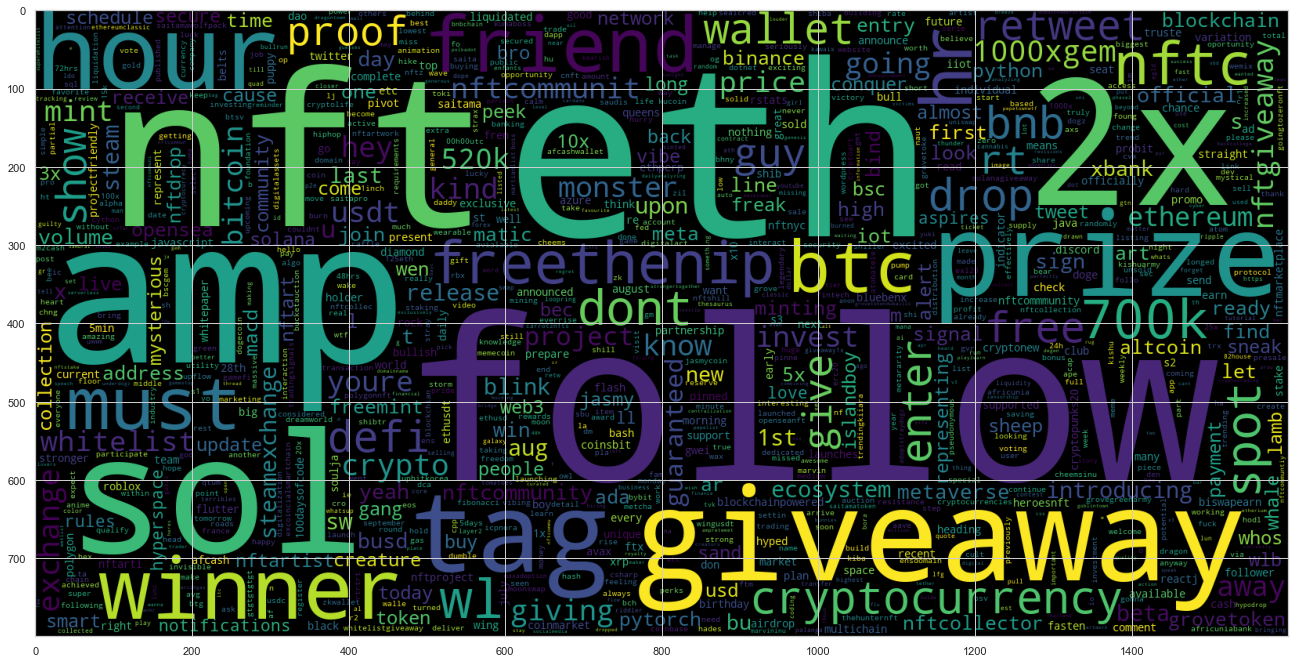

In [50]:
data_neg = df1_text['Tweet_Stop'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Finding polarity and subjectivty

In [51]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df1_text['Subjectivity'] = df1_text['Tweet_Stop'].apply(getSubjectivity)
df1_text['Polarity'] = df1_text['Tweet_Stop'].apply(getPolarity)

df1_text

,Tweet,Lower_Tweet,Tweet_Punc,Tweet_Stop,Tweet_Freq,Rare_text,Tweet_Stemmed,Tweet_Lemma,Subjectivity,Polarity
0,_Exchange: Don't blink! BETA Release of the St...,_exchange: don't blink! beta release of the st...,exchange dont blink beta release of the steame...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchang dont blink beta releas steamexchang ec...,exchange dont blink beta release steamexchange...,0.000000,0.000
1,: _FTX …,: _ftx …,ftx …,ftx …,ftx …,ftx …,ftx …,ftx …,0.000000,0.000
2,_Exchange: Don't blink! BETA Release of the St...,_exchange: don't blink! beta release of the st...,exchange dont blink beta release of the steame...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchang dont blink beta releas steamexchang ec...,exchange dont blink beta release steamexchange...,0.000000,0.000
3,: GIVEAWAY! \n\nPrize: 2X NFT\n\nMust:\n1⃣ Fol...,: giveaway! \n\nprize: 2x nft\n\nmust:\n1⃣ fol...,giveaway \n\nprize 2x nft\n\nmust\n1⃣ follow ...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,0.000000,0.000
4,: 🪐 WHITELIST GIVEAWAY! 🪐\n\nWe will be giving...,: 🪐 whitelist giveaway! 🪐\n\nwe will be giving...,🪐 whitelist giveaway 🪐\n\nwe will be giving a...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 give away • 2x guarante...,🪐 whitelist giveaway 🪐 give away • 2x guarante...,0.800000,0.400
...,...,...,...,...,...,...,...,...,...,...
9995,: First 1500 People Retweet will receive $ETH...,: first 1500 people retweet will receive $eth...,first 1500 people retweet will receive eth 1...,first 1500 people retweet receive eth 10000 fo...,first 1500 people retweet receive eth 10000 fo...,first 1500 people retweet receive eth 10000 fo...,first 1500 peopl retweet receiv eth 10000 foll...,first 1500 people retweet receive eth 10000 fo...,0.333333,0.250
9996,"_: Hey guys, if I give you $1000, which crypto...","_: hey guys, if i give you $1000, which crypto...",hey guys if i give you 1000 which cryptocurre...,hey guys give 1000 cryptocurrency would invest...,hey guys give 1000 cryptocurrency would invest...,hey guys give 1000 cryptocurrency would invest...,hey guy give 1000 cryptocurr would invest 🤔 10...,hey guy give 1000 cryptocurrency would invest ...,0.000000,0.000
9997,": 5,000,000 Konned Token Giveaway Round 1\n\...",": 5,000,000 konned token giveaway round 1\n\...",5000000 konned token giveaway round 1\n\nru...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 kon token giveaway round 1 rule 1⃣ sen...,5000000 konned token giveaway round 1 rule 1⃣ ...,0.400000,-0.200
9998,: Shill me your unique NFT under 2 ETH 🦄🦄,: shill me your unique nft under 2 eth 🦄🦄,shill me your unique nft under 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill uniqu nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,1.000000,0.375


Sentiment

In [52]:
def analysis(score):
    if score<0:
        return 'negative'
    elif score==0:
        return 'neutral'
    else:
        return 'positive'
df1_text['Sentiment']=df1_text['Polarity'].apply(analysis)
df1_text

,Tweet,Lower_Tweet,Tweet_Punc,Tweet_Stop,Tweet_Freq,Rare_text,Tweet_Stemmed,Tweet_Lemma,Subjectivity,Polarity,Sentiment
0,_Exchange: Don't blink! BETA Release of the St...,_exchange: don't blink! beta release of the st...,exchange dont blink beta release of the steame...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchang dont blink beta releas steamexchang ec...,exchange dont blink beta release steamexchange...,0.000000,0.000,neutral
1,: _FTX …,: _ftx …,ftx …,ftx …,ftx …,ftx …,ftx …,ftx …,0.000000,0.000,neutral
2,_Exchange: Don't blink! BETA Release of the St...,_exchange: don't blink! beta release of the st...,exchange dont blink beta release of the steame...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchang dont blink beta releas steamexchang ec...,exchange dont blink beta release steamexchange...,0.000000,0.000,neutral
3,: GIVEAWAY! \n\nPrize: 2X NFT\n\nMust:\n1⃣ Fol...,: giveaway! \n\nprize: 2x nft\n\nmust:\n1⃣ fol...,giveaway \n\nprize 2x nft\n\nmust\n1⃣ follow ...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,0.000000,0.000,neutral
4,: 🪐 WHITELIST GIVEAWAY! 🪐\n\nWe will be giving...,: 🪐 whitelist giveaway! 🪐\n\nwe will be giving...,🪐 whitelist giveaway 🪐\n\nwe will be giving a...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 give away • 2x guarante...,🪐 whitelist giveaway 🪐 give away • 2x guarante...,0.800000,0.400,positive
...,...,...,...,...,...,...,...,...,...,...,...
9995,: First 1500 People Retweet will receive $ETH...,: first 1500 people retweet will receive $eth...,first 1500 people retweet will receive eth 1...,first 1500 people retweet receive eth 10000 fo...,first 1500 people retweet receive eth 10000 fo...,first 1500 people retweet receive eth 10000 fo...,first 1500 peopl retweet receiv eth 10000 foll...,first 1500 people retweet receive eth 10000 fo...,0.333333,0.250,positive
9996,"_: Hey guys, if I give you $1000, which crypto...","_: hey guys, if i give you $1000, which crypto...",hey guys if i give you 1000 which cryptocurre...,hey guys give 1000 cryptocurrency would invest...,hey guys give 1000 cryptocurrency would invest...,hey guys give 1000 cryptocurrency would invest...,hey guy give 1000 cryptocurr would invest 🤔 10...,hey guy give 1000 cryptocurrency would invest ...,0.000000,0.000,neutral
9997,": 5,000,000 Konned Token Giveaway Round 1\n\...",": 5,000,000 konned token giveaway round 1\n\...",5000000 konned token giveaway round 1\n\nru...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 kon token giveaway round 1 rule 1⃣ sen...,5000000 konned token giveaway round 1 rule 1⃣ ...,0.400000,-0.200,negative
9998,: Shill me your unique NFT under 2 ETH 🦄🦄,: shill me your unique nft under 2 eth 🦄🦄,shill me your unique nft under 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill uniqu nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,1.000000,0.375,positive


Vizualization for sentiment in Ethereum tweets

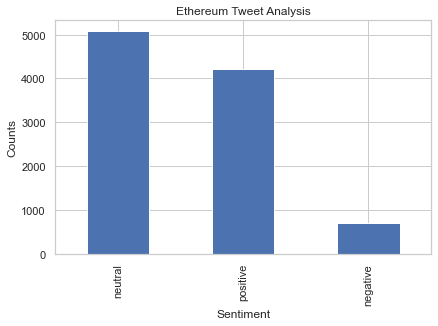

In [53]:
df1_text['Sentiment'].value_counts()
plt.title('Ethereum Tweet Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_text['Sentiment'].value_counts().plot(kind='bar')
plt.show()

Creating CSV file

In [54]:
df1_text.to_csv(r'D:\Codes\Python programming\Internship\Eth1.csv', index=False)

Unigram

In [55]:
c_vec = CountVectorizer(stop_words=stopword, ngram_range=(0,1))

# matrix of ngrams
ngrams = c_vec.fit_transform(df1_text['Tweet_Stop'])

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df_ngram3 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'Frequency', 1:'Unigram'})
df_ngram3['Polarity'] = df_ngram3['Unigram'].apply(lambda x: TextBlob(x).polarity)
df_ngram3['Subjective'] = df_ngram3['Unigram'].apply(lambda x: TextBlob(x).subjectivity)

#Sentiment
def analysis(score):
    if score<=-0.6:
        return 'negative'
    elif score==0.5:
        return 'neutral'
    elif score>=0.6:
        return 'positive'
df_ngram3['Sentiment']=df_ngram3['Polarity'].apply(analysis)


#df_ngram3 = df_ngram3[(df_ngram3['Polarity']>0 and df_ngram3['Polarity']<-0.5)]
df_ngram3 = df_ngram3[df_ngram3["Sentiment"].str.contains("None") == False]

df_ngram3

,Frequency,Unigram,Polarity,Subjective,Sentiment
54,549,kind,0.6,0.90,positive
89,204,win,0.8,0.40,positive
179,87,love,0.5,0.60,neutral
181,86,top,0.5,0.50,neutral
205,76,great,0.8,0.75,positive
...,...,...,...,...,...
5164,1,crazy,-0.6,0.90,negative
5400,1,beloved,0.7,1.00,positive
5449,1,attractive,0.8,1.00,positive
5459,1,artificial,-0.6,1.00,negative


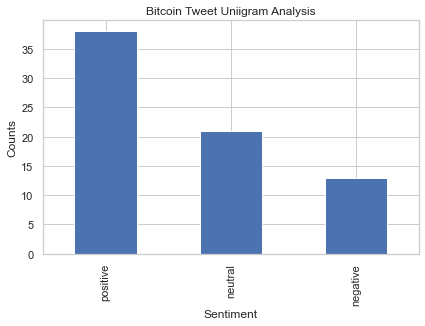

In [56]:
#Unigram Vizualization
df_ngram3['Sentiment'].value_counts()
plt.title('Bitcoin Tweet Uniigram Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_ngram3['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [57]:
ptweet3=df_ngram3[df_ngram3.Sentiment=='positive']
ptweet3

,Frequency,Unigram,Polarity,Subjective,Sentiment
54,549,kind,0.60,0.90,positive
89,204,win,0.80,0.40,positive
205,76,great,0.80,0.75,positive
206,76,good,0.70,0.60,positive
381,40,best,1.00,0.30,positive
520,23,welcome,0.80,0.90,positive
579,20,happy,0.80,1.00,positive
634,18,legendary,1.00,1.00,positive
647,18,amazing,0.60,0.90,positive
727,15,effectively,0.60,0.80,positive


In [58]:
ntweet3=df_ngram3[df_ngram3.Sentiment=='negative']
ntweet3

,Frequency,Unigram,Polarity,Subjective,Sentiment
1138,8,fucking,-0.600000,0.800000,negative
1338,6,mad,-0.625000,1.000000,negative
1400,6,base,-0.800000,1.000000,negative
1475,5,rank,-0.800000,0.900000,negative
1547,5,hate,-0.800000,0.900000,negative
1927,4,bad,-0.700000,0.666667,negative
2091,3,sick,-0.714286,0.857143,negative
2228,3,insane,-1.000000,1.000000,negative
2591,2,stupid,-0.800000,1.000000,negative
3743,1,suffers,-0.600000,0.700000,negative


In [59]:
nutweet3=df_ngram3[df_ngram3.Sentiment=='neutral']
nutweet3

,Frequency,Unigram,Polarity,Subjective,Sentiment
179,87,love,0.5,0.600000,neutral
181,86,top,0.5,0.500000,neutral
320,49,many,0.5,0.500000,neutral
488,26,interesting,0.5,0.500000,neutral
677,17,favorite,0.5,1.000000,neutral
906,11,better,0.5,0.500000,neutral
946,10,latest,0.5,0.900000,neutral
1284,6,winning,0.5,0.750000,neutral
1466,5,safe,0.5,0.500000,neutral
1487,5,pleased,0.5,1.000000,neutral


Bigram

In [60]:
c_vec = CountVectorizer(stop_words=stopword, ngram_range=(2,2))

# matrix of ngrams
ngrams = c_vec.fit_transform(df1_text['Tweet_Stop'])

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df_ngram4 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'Frequency', 1:'Bigram'})
df_ngram4['Polarity'] = df_ngram4['Bigram'].apply(lambda x: TextBlob(x).polarity)
df_ngram4['Subjective'] = df_ngram4['Bigram'].apply(lambda x: TextBlob(x).subjectivity)

#Sentiment
def analysis(score):
    if score<=-0.6:
        return 'negative'
    elif score==0.4:
        return 'neutral'
    elif score>=0.6:
        return 'positive'
df_ngram4['Sentiment']=df_ngram4['Polarity'].apply(analysis)


df_ngram4 = df_ngram4[df_ngram4["Sentiment"].str.contains("None") == False]

df_ngram4

,Frequency,Bigram,Polarity,Subjective,Sentiment
45,547,free mint,0.400,0.8,neutral
54,543,know kind,0.600,0.9,positive
55,543,kind monster,0.600,0.9,positive
63,340,guaranteed free,0.400,0.8,neutral
123,113,secure wl,0.400,0.6,neutral
...,...,...,...,...,...
15325,1,5x free,0.400,0.8,neutral
16101,1,21 available,0.400,0.4,neutral
16165,1,1x mad,-0.625,1.0,negative
16390,1,1589 rank,-0.800,0.9,negative


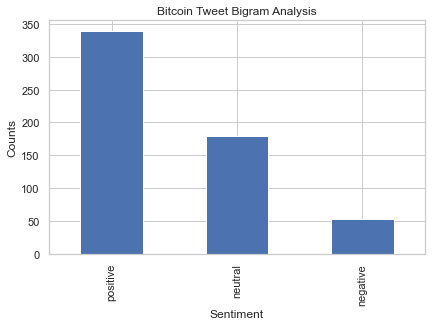

In [61]:
#Bigram Vizualization
df_ngram4['Sentiment'].value_counts()
plt.title('Bitcoin Tweet Bigram Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_ngram4['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [62]:
ptweet4=df_ngram4[df_ngram4.Sentiment=='positive']
ptweet4

,Frequency,Bigram,Polarity,Subjective,Sentiment
54,543,know kind,0.60,0.9,positive
55,543,kind monster,0.60,0.9,positive
140,87,win amp,0.80,0.4,positive
142,87,25 win,0.80,0.4,positive
236,55,win follow,0.80,0.4,positive
...,...,...,...,...,...
14824,1,amazing giveaway,0.60,0.9,positive
14825,1,amazing details,0.60,0.9,positive
15025,1,achieve best,1.00,0.3,positive
15041,1,absolutely beautiful,0.85,1.0,positive


In [63]:
ntweet4=df_ngram4[df_ngram4.Sentiment=='negative']
ntweet4

,Frequency,Bigram,Polarity,Subjective,Sentiment
1742,5,validators base,-0.800000,1.000000,negative
2093,5,base rewards,-0.800000,1.000000,negative
2266,4,rarity rank,-0.800000,0.900000,negative
2929,3,rooty fucking,-0.600000,0.800000,negative
3151,3,look insane,-1.000000,1.000000,negative
3222,3,insane one,-1.000000,1.000000,negative
3303,3,fucking roo,-0.600000,0.800000,negative
3316,3,folks hate,-0.800000,0.900000,negative
3806,2,want sick,-0.714286,0.857143,negative
4056,2,sick 11,-0.714286,0.857143,negative


In [64]:
nutweet4=df_ngram4[df_ngram4.Sentiment=='neutral']
nutweet4

,Frequency,Bigram,Polarity,Subjective,Sentiment
45,547,free mint,0.4,0.8,neutral
63,340,guaranteed free,0.4,0.8,neutral
123,113,secure wl,0.4,0.6,neutral
127,113,metaverse secure,0.4,0.6,neutral
131,111,free nft,0.4,0.8,neutral
...,...,...,...,...,...
14786,1,amp free,0.4,0.8,neutral
14948,1,ago available,0.4,0.4,neutral
14966,1,advanced cryptoscanner,0.4,0.6,neutral
15325,1,5x free,0.4,0.8,neutral


Trigram

In [65]:
c_vec = CountVectorizer(stop_words=stopword, ngram_range=(3,3))

# matrix of ngrams
ngrams = c_vec.fit_transform(df1_text['Tweet_Stop'])

# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)

# list of ngrams
vocab = c_vec.vocabulary_
df_ngram5 = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'Frequency', 1:'Trigram'})
df_ngram5['Polarity'] = df_ngram5['Trigram'].apply(lambda x: TextBlob(x).polarity)
df_ngram5['Subjective'] = df_ngram5['Trigram'].apply(lambda x: TextBlob(x).subjectivity)

#Sentiment
def analysis(score):
    if score<=-0.6:
        return 'negative'
    elif score==0.4:
        return 'neutral'
    elif score>=0.7:
        return 'positive'
df_ngram5['Sentiment']=df_ngram5['Polarity'].apply(analysis)


df_ngram5 = df_ngram5[df_ngram5["Sentiment"].str.contains("None") == False]

df_ngram5

,Frequency,Trigram,Polarity,Subjective,Sentiment
57,341,free mint enter,0.4,0.8,neutral
58,340,guaranteed free mint,0.4,0.8,neutral
61,338,2x guaranteed free,0.4,0.8,neutral
105,113,secure wl spot,0.4,0.6,neutral
109,113,metaverse secure wl,0.4,0.6,neutral
...,...,...,...,...,...
18386,1,11 edition available,0.4,0.4,neutral
18387,1,11 awesome utility,1.0,1.0,positive
18446,1,100 free spins,0.4,0.8,neutral
18449,1,100 eth win,0.8,0.4,positive


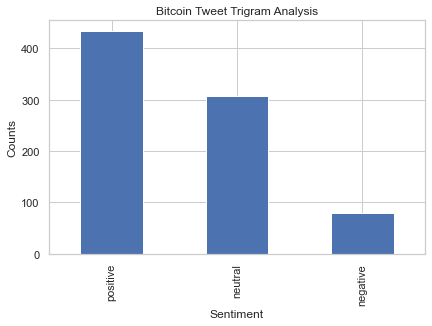

In [66]:
#Trigram Vizualization
df_ngram5['Sentiment'].value_counts()
plt.title('Bitcoin Tweet Trigram Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_ngram5['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [67]:
ptweet5=df_ngram5[df_ngram5.Sentiment=='positive']
ptweet5

,Frequency,Trigram,Polarity,Subjective,Sentiment
116,87,winners 25 win,0.80,0.4,positive
117,87,win amp enter,0.80,0.4,positive
118,87,25 win amp,0.80,0.4,positive
413,25,eth win follow,0.80,0.4,positive
473,23,230 eth win,0.80,0.4,positive
...,...,...,...,...,...
16824,1,account mining good,0.70,0.6,positive
16835,1,absolutely beautiful primed,0.85,1.0,positive
17570,1,30 eth win,0.80,0.4,positive
18387,1,11 awesome utility,1.00,1.0,positive


In [68]:
ntweet5=df_ngram5[df_ngram5.Sentiment=='negative']
ntweet5

,Frequency,Trigram,Polarity,Subjective,Sentiment
1633,5,validators base rewards,-0.800,1.0,negative
1697,5,rewards validators base,-0.800,1.0,negative
2773,3,rooty fucking roo,-0.600,0.8,negative
2998,3,look insane one,-1.000,1.0,negative
3059,3,insane one exzidia,-1.000,1.0,negative
...,...,...,...,...,...
17003,1,7068 rarity rank,-0.800,0.9,negative
17318,1,462 1x mad,-0.625,1.0,negative
17921,1,1x mad og,-0.625,1.0,negative
17949,1,1h showing dangerous,-0.600,0.9,negative


In [69]:
nutweet5=df_ngram5[df_ngram5.Sentiment=='neutral']
nutweet5

,Frequency,Trigram,Polarity,Subjective,Sentiment
57,341,free mint enter,0.4,0.8,neutral
58,340,guaranteed free mint,0.4,0.8,neutral
61,338,2x guaranteed free,0.4,0.8,neutral
105,113,secure wl spot,0.4,0.6,neutral
109,113,metaverse secure wl,0.4,0.6,neutral
...,...,...,...,...,...
17856,1,21 available beta,0.4,0.4,neutral
17905,1,200 available mint,0.4,0.4,neutral
18386,1,11 edition available,0.4,0.4,neutral
18446,1,100 free spins,0.4,0.8,neutral


Load dataset

In [70]:
data1= pd.read_csv('D:\Codes\Python programming\Internship\Eth1.csv')
data1

,Tweet,Lower_Tweet,Tweet_Punc,Tweet_Stop,Tweet_Freq,Rare_text,Tweet_Stemmed,Tweet_Lemma,Subjectivity,Polarity,Sentiment
0,_Exchange: Don't blink! BETA Release of the St...,_exchange: don't blink! beta release of the st...,exchange dont blink beta release of the steame...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchang dont blink beta releas steamexchang ec...,exchange dont blink beta release steamexchange...,0.000000,0.000,neutral
1,: _FTX …,: _ftx …,ftx …,ftx …,ftx …,ftx …,ftx …,ftx …,0.000000,0.000,neutral
2,_Exchange: Don't blink! BETA Release of the St...,_exchange: don't blink! beta release of the st...,exchange dont blink beta release of the steame...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchange dont blink beta release steamexchange...,exchang dont blink beta releas steamexchang ec...,exchange dont blink beta release steamexchange...,0.000000,0.000,neutral
3,: GIVEAWAY! \n\nPrize: 2X NFT\n\nMust:\n1⃣ Fol...,: giveaway! \n\nprize: 2x nft\n\nmust:\n1⃣ fol...,giveaway \n\nprize 2x nft\n\nmust\n1⃣ follow ...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,giveaway prize 2x nft must 1⃣ follow freetheni...,0.000000,0.000,neutral
4,: 🪐 WHITELIST GIVEAWAY! 🪐\n\nWe will be giving...,: 🪐 whitelist giveaway! 🪐\n\nwe will be giving...,🪐 whitelist giveaway 🪐\n\nwe will be giving a...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 giving away • 2x guaran...,🪐 whitelist giveaway 🪐 give away • 2x guarante...,🪐 whitelist giveaway 🪐 give away • 2x guarante...,0.800000,0.400,positive
...,...,...,...,...,...,...,...,...,...,...,...
9995,: First 1500 People Retweet will receive $ETH...,: first 1500 people retweet will receive $eth...,first 1500 people retweet will receive eth 1...,first 1500 people retweet receive eth 10000 fo...,first 1500 people retweet receive eth 10000 fo...,first 1500 people retweet receive eth 10000 fo...,first 1500 peopl retweet receiv eth 10000 foll...,first 1500 people retweet receive eth 10000 fo...,0.333333,0.250,positive
9996,"_: Hey guys, if I give you $1000, which crypto...","_: hey guys, if i give you $1000, which crypto...",hey guys if i give you 1000 which cryptocurre...,hey guys give 1000 cryptocurrency would invest...,hey guys give 1000 cryptocurrency would invest...,hey guys give 1000 cryptocurrency would invest...,hey guy give 1000 cryptocurr would invest 🤔 10...,hey guy give 1000 cryptocurrency would invest ...,0.000000,0.000,neutral
9997,": 5,000,000 Konned Token Giveaway Round 1\n\...",": 5,000,000 konned token giveaway round 1\n\...",5000000 konned token giveaway round 1\n\nru...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 konned token giveaway round 1 rules 1⃣...,5000000 kon token giveaway round 1 rule 1⃣ sen...,5000000 konned token giveaway round 1 rule 1⃣ ...,0.400000,-0.200,negative
9998,: Shill me your unique NFT under 2 ETH 🦄🦄,: shill me your unique nft under 2 eth 🦄🦄,shill me your unique nft under 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,shill uniqu nft 2 eth 🦄🦄,shill unique nft 2 eth 🦄🦄,1.000000,0.375,positive


Naive Bayes

In [71]:
#Encoding Labels and Making Train-Test Splits
x= data1['Tweet_Stop'].values
y = data1['Sentiment'].values
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)

# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x).toarray()
x_test = vec.transform(x_test).toarray()

#Building the Naive Bayes Classifier
model = MultinomialNB()
model.fit(x, y)
c=model.score(x_test, y_test)
print("Naive Bayes Accuracy score for ethereum:",c)

Naive Bayes Accuracy score for ethereum: 0.9192


In [72]:
model.predict(vec.transform(["Ethereum is great"]))

array(['positive'], dtype='<U8')

Logistic Regression

In [73]:
x= data1['Tweet_Stop'].values
y = data1['Sentiment'].values
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.4, random_state=101)

# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x).toarray()
x_test = vec.transform(x_test).toarray()
classifier= LogisticRegression(random_state=0)  
classifier.fit(x, y)  
d=classifier.score(x_test,y_test)
print("Logistic Regression Accuracy score for ethereum:",d)

Logistic Regression Accuracy score for ethereum: 0.96475


In [74]:
predictions=classifier.predict(x_test)

In [75]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    negative       0.99      0.80      0.88       181
     neutral       0.96      0.99      0.98      2611
    positive       0.97      0.94      0.95      1208

    accuracy                           0.96      4000
   macro avg       0.97      0.91      0.94      4000
weighted avg       0.96      0.96      0.96      4000



In [76]:
confusion_matrix(y_test,predictions)

array([[ 144,   26,   11],
       [   2, 2579,   30],
       [   0,   72, 1136]], dtype=int64)

KNN

In [77]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
error_rates=[]
#for k in range(1,40):
knn=KNeighborsClassifier(n_neighbors=k)
x= data1['Tweet_Stop'].values
y = data1['Sentiment'].values
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.25, random_state=42)
# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x).toarray()
x_test = vec.transform(x_test).toarray()
knn.fit(x_test,y_test)
    #pred=knn.predict(x_test)
    #error_rates.append(np.sum(y_test != pred))
knn=KNeighborsClassifier(n_neighbors=10,p=1)
knn.fit(x_test,y_test)
knn_pred=knn.predict(x_test)
print(classification_report(knn_pred,y_test))
#plt.plot(list(range(1,40)),error_rates,marker='o',mfc='red',mec='red',ms=5,ls='--')
f=knn.score(x_test,y_test)
print("accuracy score in KNN is ",f)

              precision    recall  f1-score   support

    negative       0.52      0.95      0.67        62
     neutral       1.00      0.84      0.91      1942
    positive       0.65      0.98      0.78       496

    accuracy                           0.87      2500
   macro avg       0.72      0.92      0.79      2500
weighted avg       0.91      0.87      0.88      2500

accuracy score in KNN is  0.8684


SVM

In [78]:
svc=SVC(C=8,kernel='linear',degree=4)
svc.fit(x,y)
i=svc.score(x_test,y_test)
print("Accuracy score in SVM is ",i)

Accuracy score in SVM is  0.9732


In [79]:
pred=svc.predict(x_test)

In [80]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.97      0.88      0.92       113
     neutral       0.98      0.99      0.98      1632
    positive       0.96      0.96      0.96       755

    accuracy                           0.97      2500
   macro avg       0.97      0.94      0.95      2500
weighted avg       0.97      0.97      0.97      2500



Random Forest Classifier

In [81]:
rf=RandomForestClassifier(n_estimators=20)
rf.fit(x,y)
j=rf.score(x_test,y_test)
print("Accuracy score in Random Forest Classifier is ",j)

Accuracy score in Random Forest Classifier is  0.974


In [82]:
pred=rf.predict(x_test)

In [83]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       1.00      0.84      0.91       113
     neutral       0.97      1.00      0.98      1632
    positive       0.99      0.94      0.97       755

    accuracy                           0.97      2500
   macro avg       0.99      0.93      0.95      2500
weighted avg       0.97      0.97      0.97      2500



Creating Dataframe for algorithm accuracy

In [84]:
data2={'Naive Bayes':[a,c],'Logistic Regression':[b,d],'KNN':[e,f],'SVM':[g,i],'Random Forest Classifier':[h,j]}
df1=pd.DataFrame(data2,index=['Bitcoin','Ethereum'])
df1

,Naive Bayes,Logistic Regression,KNN,SVM,Random Forest Classifier
Bitcoin,0.9004,0.94050,0.7796,0.9492,0.9412
Ethereum,0.9192,0.96475,0.8684,0.9732,0.9740


Visualizing the accuracy

In [85]:
data3={'Algorithms':['Naive Bayes','Logistic Regression','KNN','SVM','Random Forest Classifier']}
df2=pd.DataFrame(data3,index=[1,2,3,4,5])
df2

,Algorithms
1,Naive Bayes
2,Logistic Regression
3,KNN
4,SVM
5,Random Forest Classifier


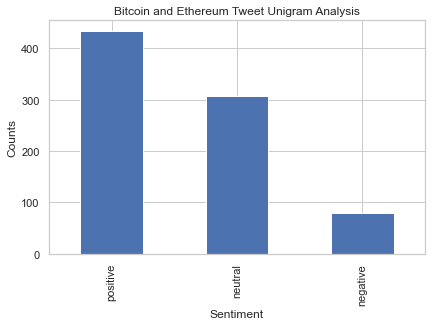

In [86]:
#Trigram Vizualization
df_ngram5['Sentiment'].value_counts()
plt.title('Bitcoin and Ethereum Tweet Unigram Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_ngram5['Sentiment'].value_counts().plot(kind='bar')
plt.show()

## Conclusion

In [93]:
print("Bitcoin Tweets:")
print(df_text['Sentiment'].value_counts())
print("\n\nEthereum Tweets:")
print(df1_text['Sentiment'].value_counts())

Bitcoin Tweets:
neutral     5076
positive    4216
negative     708
Name: Sentiment, dtype: int64


Ethereum Tweets:
neutral     6527
positive    3020
negative     453
Name: Sentiment, dtype: int64


In [94]:
print("Bitcoin Tweets:")
print(df_ngram['Sentiment'].value_counts())
print("\n\nEthereum Tweets:")
print(df_ngram3['Sentiment'].value_counts())

Bitcoin Tweets:
positive    101
neutral      24
negative     24
Name: Sentiment, dtype: int64


Ethereum Tweets:
positive    38
neutral     21
negative    13
Name: Sentiment, dtype: int64


In [96]:
df1.mean(axis = 0, skipna = True)

Naive Bayes                 0.909800
Logistic Regression         0.952625
KNN                         0.824000
SVM                         0.961200
Random Forest Classifier    0.957600
dtype: float64

In [99]:
df1.mean(axis = 1)

Bitcoin     0.90218
Ethereum    0.93991
dtype: float64